In [1]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import zipfile
from google.colab import drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pandas numpy matplotlib pillow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import zipfile

# Configuration - SET THESE VALUES
ZIP_PATH = "/content/drive/MyDrive/self-driving-cars.zip"  # Path to your zip file
EXTRACT_PATH = "/content/dataset"  # Where to extract files
IMAGE_SUBFOLDER = "images"  # Subfolder containing images (change if different)

# Unzip dataset
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

print(f"Dataset extracted to: {EXTRACT_PATH}")
print("Contents:", os.listdir(EXTRACT_PATH))

Dataset extracted to: /content/dataset
Contents: ['labels_val.csv', 'labels_trainval.csv', 'images', 'labels_train.csv']


In [15]:
import pandas as pd
import numpy as np

# Load and prepare data
labels_path = os.path.join(EXTRACT_PATH, "labels_train.csv")
labels_df = pd.read_csv(labels_path)

# Verify required columns
required_columns = ['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id']
missing_cols = [col for col in required_columns if col not in labels_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Clean data
labels_df = labels_df.dropna(subset=required_columns)

# Create class mapping (UPDATE WITH YOUR CLASSES)
class_mapping = {
    1: "pedestrian",
    2: "car",
    3: "cyclist",
    # Add all your classes here
}
labels_df['class_name'] = labels_df['class_id'].map(class_mapping).fillna('unknown')

print("Data loaded successfully!")
print("Class distribution:\n", labels_df['class_name'].value_counts())

Data loaded successfully!
Class distribution:
 class_name
pedestrian    101314
unknown        14142
cyclist        10637
car             6313
Name: count, dtype: int64


Processing image: 1479500586117425729.jpg
Found 12 annotations


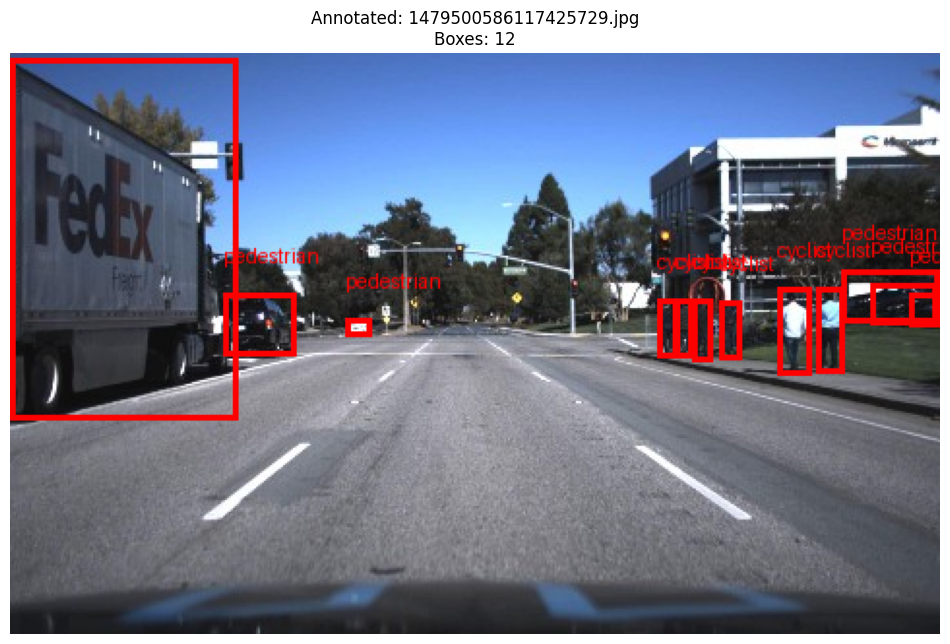

In [16]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def visualize_image(df, image_filename=None, image_subfolder=IMAGE_SUBFOLDER):
    try:
        # Select image if not specified
        if image_filename is None:
            image_filename = np.random.choice(df['frame'].unique())
        print(f"Processing image: {image_filename}")

        # Get annotations
        annotations = df[df['frame'] == image_filename]
        print(f"Found {len(annotations)} annotations")

        # Find image file (handle different extensions)
        image_path = None
        possible_extensions = ['', '.jpg', '.jpeg', '.png']
        base_path = os.path.join(EXTRACT_PATH, image_subfolder)

        for ext in possible_extensions:
            test_path = os.path.join(base_path, f"{image_filename}{ext}")
            if os.path.exists(test_path):
                image_path = test_path
                break

        if image_path is None:
            raise FileNotFoundError(f"Could not find image {image_filename} in {base_path}")

        # Open image
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image)

        # Try to load font
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            font = ImageFont.load_default()

        # Draw annotations
        for _, row in annotations.iterrows():
            try:
                # Convert coordinates to integers
                xmin = int(float(row['xmin']))
                ymin = int(float(row['ymin']))
                xmax = int(float(row['xmax']))
                ymax = int(float(row['ymax']))

                # Get class name safely
                class_name = str(row.get('class_name', row['class_id']))

                # Draw bounding box
                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
                draw.text((xmin, ymin - 25), class_name, fill="red", font=font)
            except Exception as e:
                print(f"Warning: Could not draw annotation {row}: {str(e)}")
                continue

        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Annotated: {os.path.basename(image_path)}\nBoxes: {len(annotations)}")
        plt.show()

    except Exception as e:
        print(f"Error visualizing image: {str(e)}")
        print("\nDebugging info:")
        print(f"Image filename: {image_filename}")
        print(f"Image search path: {base_path}")
        if os.path.exists(base_path):
            print(f"Available images in directory: {len(os.listdir(base_path))}")
            print(f"First 5 files: {os.listdir(base_path)[:5]}")
        else:
            print("Image directory not found!")
        print("Sample annotations:\n", annotations.head() if len(annotations) > 0 else "No annotations found")

# Example usage
visualize_image(labels_df)